In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np

from ete3 import Tree, PhyloTree, TreeStyle
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, PrecisionRecallDisplay, precision_recall_curve, auc

In [2]:
taxa_data = pd.read_csv("data/dataset_CH/microbiote_data/lung/lung_16S_taxa_table_all_samples.csv", sep=";", index_col=0)
taxa_data.reset_index(inplace=True, names="ASV")

taxa_data.head()

,ASV,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,ASV10,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NaN
1,ASV13,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NaN
2,ASV15,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Veillonella,dispar
3,ASV29,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Veillonellaceae,Veillonella,atypica
4,ASV3,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,NaN


In [3]:
delta_lung = pd.read_csv("data/dataset_CH/clean_data/lung_clean/delta_lung_16S.csv")
lung_count = pd.read_csv("data/dataset_CH/microbiote_data/lung/lung_16St_asv_table_all_samples.csv", sep = ";", index_col=0).reset_index(names="id_sample")

In [4]:
merged_data = delta_lung[delta_lung.Time == "M0"].merge(lung_count)
merged_data.head()
merged_data = pd.get_dummies(data=merged_data, columns=["group"], drop_first=True)

train, test = train_test_split(merged_data, random_state=50, shuffle=True, test_size=0.2, stratify=merged_data.group_Improvement)

In [5]:
train.group_Improvement.sum() / len(train), test.group_Improvement.sum() / len(test)

(0.7413793103448276, 0.7333333333333333)

In [6]:
test.head()

,id_patient,bmi_zscore_M0,bmi_zscore_M12,delta_bmi,X,id_sample,Time,Groupe,Sexe,Age,...,ASV984,ASV986,ASV987,ASV99,ASV991,ASV994,ASV995,ASV998,ASV999,group_Improvement
65,LIB85,0.1152,-0.1037,-0.2189,358,D4C,M0,AFter,F,5.347945,...,0,0,0,0,0,0,0,0,0,False
72,LIB97,-0.0353,1.3954,1.4307,384,B2C,M0,AFter,F,11.906849,...,0,0,0,0,0,0,0,0,0,True
57,LIB59,1.4914,2.3644,0.8730,290,E6C,M0,AFter,F,11.687671,...,0,0,0,0,0,0,0,0,0,True
0,LIB1,1.0432,1.1012,0.0580,2,D6C,M0,AFter,M,11.739726,...,37,0,0,0,0,0,0,0,0,True
1,LIB10,-0.2122,-1.5807,-1.3685,4,N7C,M0,AFter,M,4.490411,...,0,0,0,0,0,0,0,0,0,False


In [7]:
taxa_columns = taxa_data.columns[1:]

tree = Tree(name="Bacteria")
node_dict = {"Bacteria": tree}


for _, row in taxa_data.iterrows():
    lineage = (row[1:]._append(row[:1])).dropna().to_list() # Append ASV to the end
    # lineage = row[1:].dropna().to_list()
    current_node = tree

    for taxon in lineage:
        if taxon not in node_dict:
            new_node = current_node.add_child(name=taxon)
            node_dict[taxon] = new_node
        current_node = node_dict[taxon]

In [8]:
G = nx.DiGraph()

taxa_to_id = {"Bacteria": 0}
id_to_taxa = {0: "Bacteria"}
idx = 1

for node in tree.traverse():
    for child in node.children:
        taxa_to_id[child.name] = idx
        id_to_taxa[idx] = child.name
        idx += 1
        G.add_edge(node.name, child.name)

    # Add edges connecting the leaves of the same parent
    leaves = [child.name for child in node.children if child.is_leaf()]
    for i in range(len(leaves)):
        for j in range(len(leaves)):
            if i!=j:
                G.add_edge(leaves[i], leaves[j])

# Convert graph to adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

assert len(adj_matrix) == len(id_to_taxa) and len(id_to_taxa) == len(taxa_to_id)

for i in range(len(adj_matrix)):
    for j in range(len(adj_matrix)):
        if adj_matrix[i,j] == 1:
            adj_matrix[j,i] = 1

In [9]:
row_idx, col_idx = np.where(adj_matrix == 1)

# Stack them into a COO matrix format
coo_matrix = np.vstack((row_idx, col_idx))

print(coo_matrix)

[[   0    0    0 ... 1255 1256 1256]
 [   1    2    3 ... 1256 1059 1255]]


In [10]:
def propagate(node):
    if node.is_leaf():
        return node.count
    count = sum([propagate(child) for child in node.children])
    node.add_feature("count", count)
    return count

In [11]:
def get_dataset(df):
    dataset = []
    columns = [i for i in df.columns if "ASV" in i]
    
    for _, row in df.iterrows():
    
        node_features = np.zeros((len(id_to_taxa),1))
        edge_features = np.zeros((coo_matrix.shape[1], 1))
        
        # reset
        for node in tree.traverse():
            node.add_feature("count", 0)
        
        present_asv = [asv for asv in columns if row[asv] > 0]
        for asv in present_asv:
            leaf = tree.get_leaves_by_name(asv)[0]
            leaf.add_feature("count", row[asv])
    
        propagate(tree)
    
        for node in tree.traverse():
            idx = taxa_to_id[node.name]
            if node.count > 0:
                node_features[idx, 0] = node.count
            for child in node.children:
                if child.count > 0:
                    idy = taxa_to_id[child.name]
                    mask = ((coo_matrix[0] == idx) & (coo_matrix[1] == idy) | (coo_matrix[0] == idy) & (coo_matrix[1] == idx))
                    edge_features[mask, 0] = 1
            
            leaves = [child.name for child in node.children if child.is_leaf() and child.count > 0]
            for i in range(len(leaves)):
                for j in range(len(leaves)):
                    if i!=j:
                        idx = taxa_to_id[leaves[i]]
                        idy = taxa_to_id[leaves[j]]
                        mask = ((coo_matrix[0] == idx) & (coo_matrix[1] == idy) | (coo_matrix[0] == idy) & (coo_matrix[1] == idx))
                        edge_features[mask, 0] = 1
        dataset.append(Data(
            x=torch.tensor(node_features / node_features.max(), dtype=torch.float32),
            edge_index=torch.tensor(coo_matrix),
            edge_attr=torch.tensor(edge_features, dtype=torch.float32),
            y = torch.tensor(row["group_Improvement"], dtype=torch.float32)
        ))

    return dataset

In [12]:
train_list = get_dataset(train)
test_list = get_dataset(test)

In [13]:
len(train_list), len(test_list)

(58, 15)

In [14]:
complete_train_loader = DataLoader(train_list, batch_size=4, shuffle=True)
complete_test_loader = DataLoader(test_list, batch_size=4, shuffle=False)

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool, BatchNorm
from torch_geometric.nn import MLP

class GIN(torch.nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1, num_layers=2, dropout=0.5):
        super(GIN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()  # BatchNorm layer
        self.dropout = dropout
        
        # First layer: input_dim -> hidden_dim
        mlp = MLP([input_dim, hidden_dim])
        self.convs.append(GINConv(mlp))
        self.bns.append(BatchNorm(hidden_dim))  # BatchNorm for first layer

        # Middle layers: hidden_dim -> hidden_dim
        for _ in range(num_layers - 1):
            mlp = MLP([hidden_dim, hidden_dim])
            self.convs.append(GINConv(mlp))
            self.bns.append(BatchNorm(hidden_dim))  # BatchNorm for each layer
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)  # Final classification layer

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)  # Apply batch normalization
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)  # Apply dropout

        x = global_add_pool(x, batch)  # Sum pooling for graph-level representation
        x = self.fc(x)
        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = GIN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = F.binary_cross_entropy_with_logits

In [17]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch).squeeze() 
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

def evaluate_model(model, val_loader, metric, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch).squeeze()  # Forward pass
            pred = F.sigmoid(out).cpu()  # Store predictions (move to CPU)
            if pred.shape[0] > 1:
                predictions += pred.flatten().tolist()
                true_labels += batch.y.cpu().flatten().tolist()  # Store true labels
            else:
                predictions.append(pred.item())
                true_labels.append(batch.y.cpu().item())  # Store true labels
    return metric(true_labels, predictions), true_labels, predictions

In [18]:
from sklearn.model_selection import KFold

torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# k-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_aucs = []
epochs = 30
criterion = F.binary_cross_entropy_with_logits
metric = roc_auc_score
lr = 1e-3
weight_decay = 1e-5

for fold, (train_idx, val_idx) in enumerate(kf.split(train_list)):
    print(f"Fold {fold+1}/{k}")

    train_dataset = [train_list[i] for i in train_idx]
    val_dataset = [train_list[i] for i in val_idx]
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    model = GIN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):  # Adjust epochs
        train_model(model, train_loader, optimizer, criterion, device)

    auc, _, _ = evaluate_model(model, val_loader, metric, device)
    test_auc, _, _ = evaluate_model(model, complete_test_loader, metric, device)
    cv_aucs.append(auc)
    print(f"Fold {fold+1} ROC-AUC: {auc:.4f}, Test ROC-AUC: {test_auc:.4f}")

print(f"Mean AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f}")

Fold 1/5
Fold 1 ROC-AUC: 0.4219, Test ROC-AUC: 0.5227
Fold 2/5
Fold 2 ROC-AUC: 0.2031, Test ROC-AUC: 0.5455
Fold 3/5
Fold 3 ROC-AUC: 0.3704, Test ROC-AUC: 0.4545
Fold 4/5
Fold 4 ROC-AUC: 0.4375, Test ROC-AUC: 0.4091
Fold 5/5
Fold 5 ROC-AUC: 0.7000, Test ROC-AUC: 0.5000
Mean AUC: 0.4266 ± 0.1600


Train AUC: 0.7131782945736433, Test AUC: 0.4090909090909091


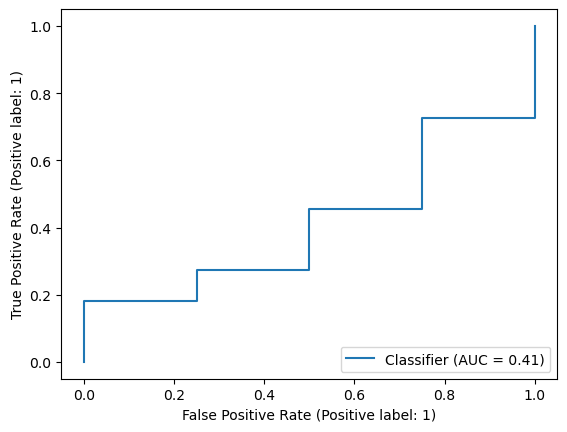

In [19]:
model = GIN().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
for epoch in range(epochs):  # Use same number of epochs as in CV
    train_model(model, complete_train_loader, optimizer, criterion, device)
train_auc, _, _ = evaluate_model(model, complete_train_loader, metric, device)
model.train()
test_auc, true_labels, predictions = evaluate_model(model, complete_test_loader, metric, device)
print(f"Train AUC: {train_auc}, Test AUC: {test_auc}")


RocCurveDisplay.from_predictions(true_labels, predictions)

In [20]:
# torch.save(model, "experiment2_cv5_model_auc_0.66.pt")
model = torch.load("phylo_gnn/experiments/best_model_exp_1-f.pt")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_38540\1029592855.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("phylo_gnn/experiments/best_model_exp_1

ValueError: y_true takes value in {} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

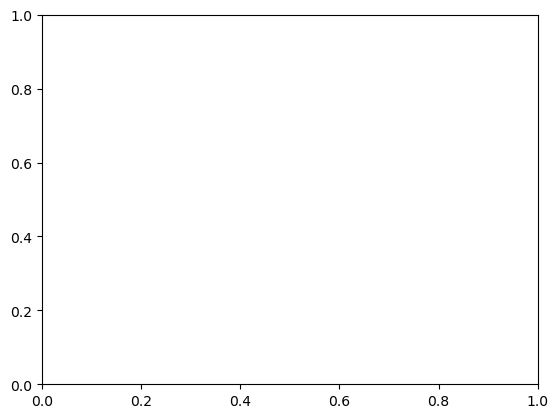

In [23]:
import matplotlib.pyplot as plt

# train_auc, train_true_labels, train_predictions = evaluate_model(model, complete_train_loader, metric, device)
# model.train()
# test_auc, test_true_labels, test_predictions = evaluate_model(model, complete_test_loader, metric, device)

fig, ax = plt.subplots()

# RocCurveDisplay.from_predictions(train_true_labels, train_predictions, name="Train Set (n=58)", ax=ax)
# RocCurveDisplay.from_predictions(test_true_labels, test_predictions, name="Test Set (n=15)", ax=ax)
RocCurveDisplay.from_predictions([], [], name="Complete Set (n=73)", ax=ax, plot_chance_level=True)

plt.show()

In [ ]:
fig, ax = plt.subplots()

PrecisionRecallDisplay.from_predictions(train_true_labels, train_predictions, name="Train Set (n=58)", ax=ax)
PrecisionRecallDisplay.from_predictions(test_true_labels, test_predictions, name="Test Set (n=15)", ax=ax)
PrecisionRecallDisplay.from_predictions(test_true_labels + train_true_labels, test_predictions + train_predictions, name="Complete Set (n=73)", ax=ax, plot_chance_level=True)

ax.set_ylim([0,1.02])
ax.set_xlim([0,1.02])
plt.show()

In [ ]:
precision, recall, thresholds = precision_recall_curve(test_true_labels + train_true_labels, test_predictions + train_predictions)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)